Question checklist
1. Cartpole - without baseline
2. Cartpole - with baseline
3. CartPole - Actor Critic
4. Pendulum - without basline 
5. Pendulum - with baseline
6. Pendulum - Actor Critic
7. Pendulum - Gaussian Policy implemented for Pendulum

Link to video: https://drive.google.com/file/d/1PU9xcWmo7GP7lj_-LWVOuPvlwOTFXz_F/view?usp=sharing

Cart pole

Question 1. 
Both with and without baseline follow similar code except subtraction of mean value from rewards.
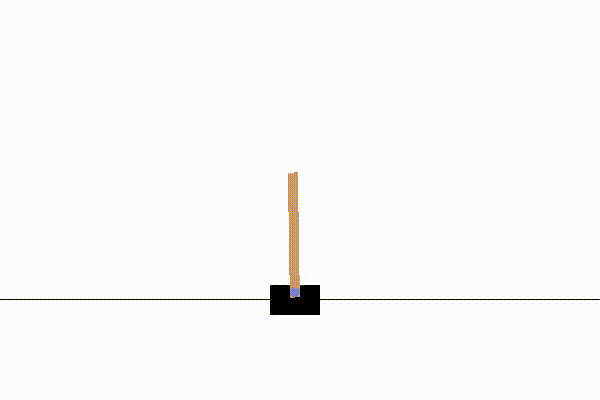

In [1]:
import numpy as np
import gym
from gym.spaces import Discrete, Box
import torch.nn as nn
import torch
import torch.optim as optimizer
import torch.nn.functional as F
import matplotlib.pyplot as plt


class MLP(nn.Module):
    

    def __init__(self, sizes, activation=nn.ReLU(inplace=True), output_activation=None):
    # Setup a neural network where input is of dimensions of the state and output is corresponding to number of actions.
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes) - 2:
                layers.append(activation)
        self.fwd = nn.Sequential(*layers)
    
    def forward(self, x):
        return F.softmax(self.fwd(x), dim=-1)

def discount_rewards(rewards, gamma=0.99):
    # Cumulative discounted sum
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    r = r[::-1].cumsum()[::-1]
    # Intuitively this means if the network predicts what it expects it should not do too much about it Stabalizes and speeds up the training
    # Reduce the variance 
    return r - r.mean() # Subtracting the baseline reward: A simple state and time independant baseline
    # return r # for vanilla gradient without baseline

def train(env_name='CartPole-v0', num_episodes=1500, batch_size=10, lr=1e-2, gamma=0.99):

    env = gym.make(env_name)
    model = MLP([env.observation_space.shape[0], 32, 20, env.action_space.n])

    # Lists for storing episode values
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []

    batch_counter = 1
    opt = optimizer.Adam(model.parameters(), lr) # Adam optimiser
    action_space = np.arange(env.action_space.n) # Action space of the environment, discrete for cartpole

    for ep in range(num_episodes):
        # Reset the environment
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        complete = False
        while complete == False:
            action_probs = model(torch.FloatTensor(s_0)).detach().numpy()
            action = np.random.choice(action_space, p=action_probs) # choose action based on action probabilities given by network
            s1, r, complete, _ = env.step(action)
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s1
            if complete:
                
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))

                if batch_counter == batch_size:
                    # Here, we prepare the batches for training
                    # Create and add states, reward and actions to tensor
                    opt.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    action_tensor = torch.LongTensor(batch_actions)

                    # Convert the probs by the model to log probabilities
                    log_probs = torch.log(model(state_tensor))
                    # Calculate update value J = Returns * log_probalities of actions
                    selected_log_probs = reward_tensor * log_probs[np.arange(len(action_tensor)), action_tensor]
                    loss = -selected_log_probs.mean()
                    # Do the update gradient descent(with negative reward hence is gradient ascent) 
                    loss.backward()
                    opt.step()

                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1

                if ep%30 == 0:
                    print("\rEp: {} Average of last 30: {:.2f}".format(
                        ep + 1, np.mean(total_rewards[-30:])), end="")
    
    return total_rewards

if __name__ == '__main__':

    rewards = train()
    window = 10
    smoothed_rewards = [np.mean(rewards[i-window:i+1]) if i > window 
                        else np.mean(rewards[:i+1]) for i in range(len(rewards))]

    plt.figure(figsize=(12,8))
    plt.plot(rewards)
    # plt.plot(smoothed_rewards)
    plt.ylabel('Average Rewards per 30 episodes')
    plt.xlabel('Episodes')
    plt.show()

Ep: 1471 Average of last 30: 149.70

<Figure size 1200x800 with 1 Axes>

Comparison between CartPole w baseline vs CartPole wo baseline

CartPole with baseline
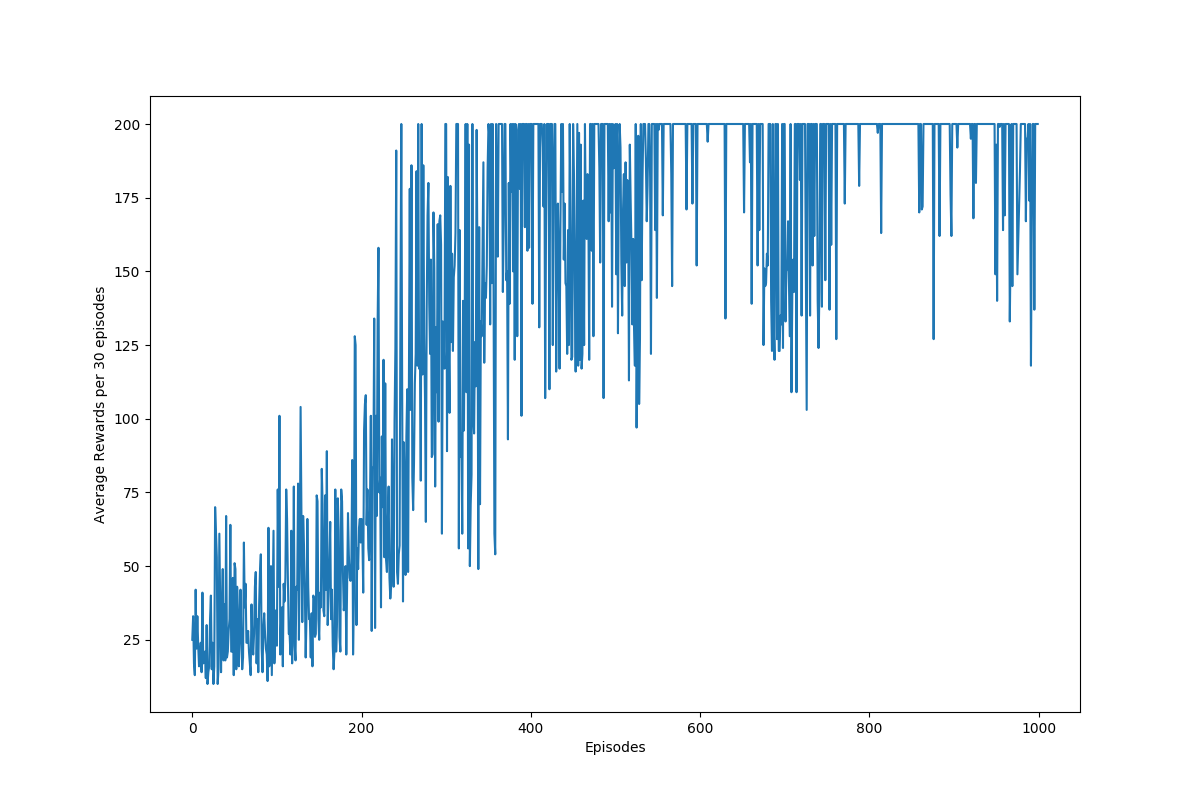

CartPole without basline
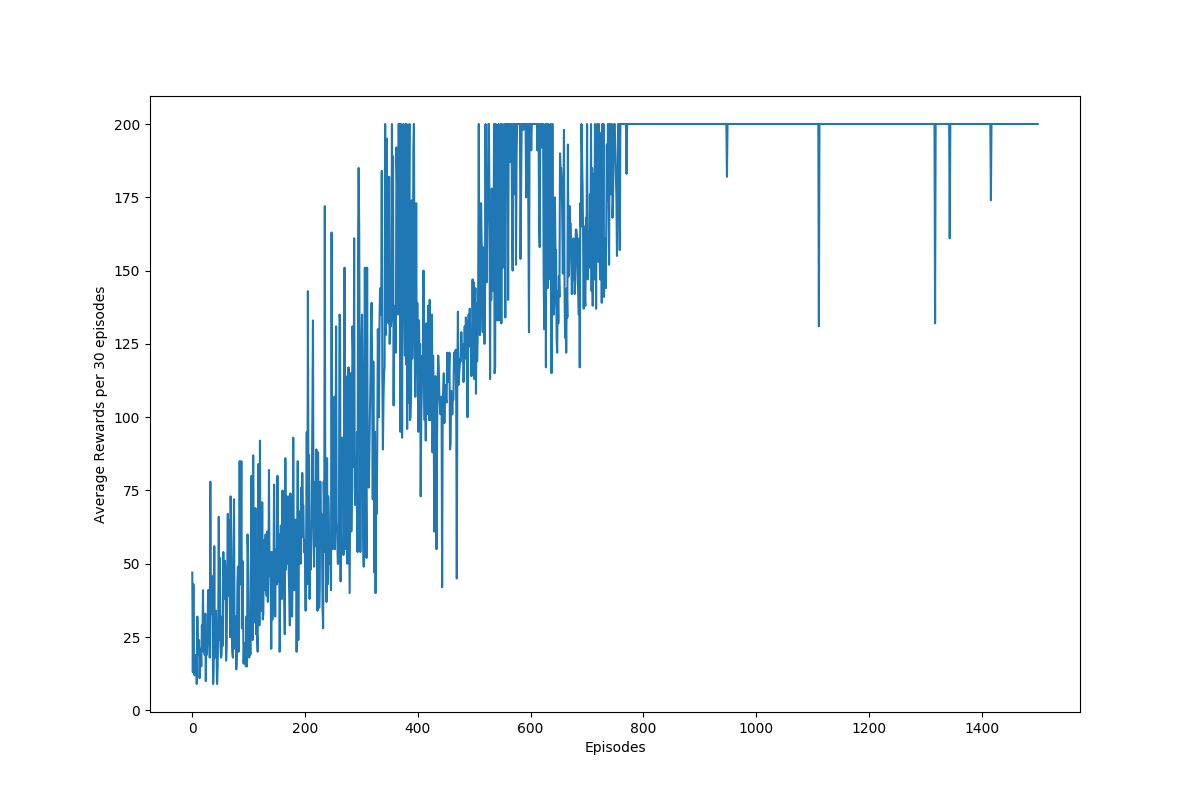

We can clearly see that with a baseline we are able to achieve covergence faster and variance is also low. While convergence is achieved by baseline in 800-900 episodes, for the one without baseline we go uptil 1300-1400 episodes.

3. CartPole Actor Critic

The algorihtm followed for implementation followed by using advantage function--
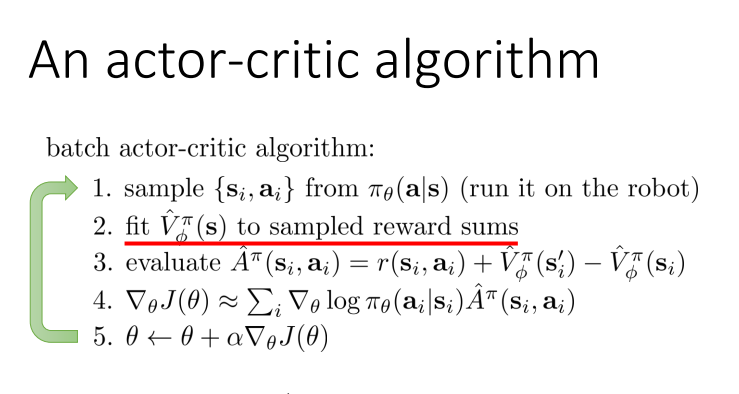

/home/bhavya/mll/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/bhavya/mll/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


episode: 0  score: 39.0
episode: 1  score: 17.0
episode: 2  score: 22.0
episode: 3  score: 23.0
episode: 4  score: 12.0
episode: 5  score: 14.0
episode: 6  score: 71.0
episode: 7  score: 45.0
episode: 8  score: 23.0
episode: 9  score: 62.0
episode: 10  score: 42.0
episode: 11  score: 44.0
episode: 12  score: 16.0
episode: 13  score: 11.0
episode: 14  score: 10.0
episode: 15  score: 14.0
episode: 16  score: 16.0
episode: 17  score: 13.0
episode: 18  score: 30.0
episode: 19  score: 9.0
episode: 20  score: 29.0
episode: 21  score: 21.0
episode: 22  score: 74.0
episode: 23  score: 39.0
episode: 24  score: 11.0
episode: 25  score: 22.0
episode: 26  score: 13.0
episode: 27  score: 12.0
episode: 28  score: 33.0
episode: 29  score: 13.0
episode: 30  score: 25.0
episode: 31  score: 44.0
episode: 32  score: 15.0
episode: 33  score: 56.0
episode: 34  score: 12.0
episode: 35  score: 49.0
episode: 36  score: 15.0
episode: 37  score: 15.0
episode: 38  score: 10.0
episode: 39  score: 14.0
episode: 40

episode: 326  score: 165.0
episode: 327  score: 153.0
episode: 328  score: 117.0
episode: 329  score: 149.0
episode: 330  score: 51.0
episode: 331  score: 169.0
episode: 332  score: 77.0
episode: 333  score: 157.0
episode: 334  score: 153.0
episode: 335  score: 200.0
episode: 336  score: 148.0
episode: 337  score: 52.0
episode: 338  score: 103.0
episode: 339  score: 122.0
episode: 340  score: 31.0
episode: 341  score: 151.0
episode: 342  score: 91.0
episode: 343  score: 109.0
episode: 344  score: 200.0
episode: 345  score: 147.0
episode: 346  score: 200.0
episode: 347  score: 133.0
episode: 348  score: 107.0
episode: 349  score: 67.0
episode: 350  score: 145.0
episode: 351  score: 48.0
episode: 352  score: 181.0
episode: 353  score: 157.0
episode: 354  score: 200.0
episode: 355  score: 133.0
episode: 356  score: 30.0
episode: 357  score: 200.0
episode: 358  score: 105.0
episode: 359  score: 125.0
episode: 360  score: 200.0
episode: 361  score: 114.0
episode: 362  score: 122.0
episode: 

episode: 639  score: 200.0
episode: 640  score: 200.0
episode: 641  score: 200.0
episode: 642  score: 200.0
episode: 643  score: 200.0
episode: 644  score: 200.0
episode: 645  score: 200.0
646


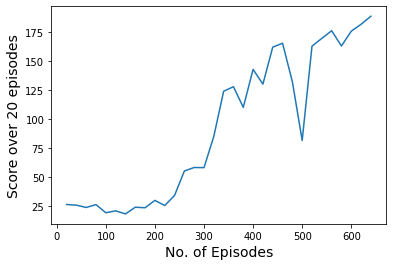

In [2]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class Critic(nn.Module):

    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = 16

        self.hidden_1 = nn.Linear(self.input_size, self.hidden_size)
        self.hidden_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

    def forward(self, input_):
        output_1 = F.relu(self.hidden_1(input_))
        output_2 = F.relu(self.hidden_2(output_1))
        output = self.out(output_2)
        return output


class Actor(nn.Module):

    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        hidden_size = 16

        self.hidden_1 = nn.Linear(self.input_size, hidden_size)
        self.hidden_2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, self.output_size)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, input_):
        output_1 = F.relu(self.hidden_1(input_))
        output_2 = F.relu(self.hidden_2(output_1))
        output = F.softmax(self.out(output_2), dim=1)
        return output


# Randomly pick an action, with probabilities from the actor network
def get_action(actor, state):
    input_ = torch.FloatTensor(state).reshape([1, 4])

    actor.eval()
    with torch.no_grad():
        output = actor.forward(input_)

    choice = torch.multinomial(output, 1).item()

    # print(f'output: {output} choice: {choice} ')

    return choice


def train_model(critic, actor, prev_states, actions, rewards, curr_states):
    discount_factor = 0.99

    # Get value predictions of the current states, without training
    critic.eval()
    with torch.no_grad():
        predicted_value_current_state = critic.forward(torch.FloatTensor(curr_states)).detach() # compute V^(s')

    # Since we are finished after the last element, we should predict 0 here
    predicted_value_current_state[-1] = 0

    # Estimate the 'real' value as the reward + the (discounted) predicted value of the current state
    # V(s) = r + gamma*V^(s')
    real_previous_value = torch.FloatTensor(rewards).reshape(-1, 1) + discount_factor * predicted_value_current_state
    
    prev_states_tensor = torch.FloatTensor(prev_states)

    # Forward propagate to get value predictions for the previous state
    critic.train()
    predicted_value_previous_state = critic.forward(prev_states_tensor) # Compute V^(s)

    # Forward propagate to get action probabilities for the previous state
    actor.train()
    actor_output = actor.forward(prev_states_tensor) 

    # Calculate the "advantage" -- how much better/worse we did than what we predicted
    #A(s,t) = r_{t+1} + gamma*V^(s') - V^(s)
    advantage = (real_previous_value - predicted_value_previous_state.detach())

    # Decide what would have been the best action
    def best_action(action, advantage_):
        if action is 0:
            return 0 if advantage_ > 0 else 1
        else:
            return 1 if advantage_ > 0 else 0

    # Get the action to learn for every pair of action and advantage, best action is chosen
    action_to_learn = torch.LongTensor(list(
        map(lambda x: best_action(x[0], x[1]), zip(actions, advantage))))

    # train the actor
    actor_loss = F.cross_entropy(actor_output, action_to_learn)
    actor.optimizer.zero_grad()
    actor_loss.backward()
    nn.utils.clip_grad_norm(actor.parameters(), 0.5)
    actor.optimizer.step()

    # train the critic
    critic_loss = F.mse_loss(predicted_value_previous_state, real_previous_value)
    critic.optimizer.zero_grad()
    critic_loss.backward()
    nn.utils.clip_grad_norm(critic.parameters(), 0.5)
    critic.optimizer.step()


# After drawing plot, continue running while not stealing focus
def release_plot(interval):
    backend = plt.rcParams['backend']
    if backend in matplotlib.rcsetup.interactive_bk:
        fig_manager = matplotlib._pylab_helpers.Gcf.get_active()
        if fig_manager is not None:
            canvas = fig_manager.canvas
            if canvas.figure.stale:
                canvas.draw()
            canvas.start_event_loop(interval)


def train():
    render = False
    draw_plot = False

    # Number of max scores in a row that we regard as success
    success_count = 10

    env = gym.make('CartPole-v0')

    # In CartPole the maximum length of an episode is 200
    # Max reward we want to attain
    max_score = 200

    # Get sizes of state and action from the environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    actor = Actor(input_size=state_size, output_size=action_size)
    critic = Critic(input_size=state_size, output_size=1)

    scores, episodes = [], []

    episode = 0
    all_done = False

    if draw_plot:
        plt.ion()
        plt.show()

    while not all_done:
        env_done = False
        score = 0
        state = env.reset()

        states, next_states, actions, rewards = [], [], [], []

        # Run one episode, i.e. until we lose or succeed
        while not env_done:
            if render:
                env.render()

            action = get_action(actor, state)

            # Perform an action in the environment
            next_state, reward, env_done, info = env.step(action)
            score += reward

            # If an action makes the episode end, give it a penalty
            reward_mod = reward if (not env_done or score == max_score) else -5

            states.append(state)
            next_states.append(next_state)
            actions.append(action)
            rewards.append(reward_mod)

            state = next_state

            if env_done:
                train_model(critic, actor, states, actions, rewards, next_states)

                scores.append(score)
                episodes.append(episode)

                if draw_plot:
                    plt.plot(episodes, scores, 'b')
                    release_plot(1)

                print('episode:', episode, ' score:', score)

                # If we have success_count perfect runs in a row, stop training
                if len(scores) >= success_count and np.mean(scores[-success_count:]) == max_score:
                    all_done = True

        episode += 1

    env.close()
    return scores,episodes

if __name__ == '__main__':
    score,episode = train()
    print(len(episode))
    score_plot = []
    episode_plot =[]
    for i in range(20,len(episode),20):
        score_plot.append(np.mean(score[i-20:i]))
        episode_plot.append(i) 
    # for i in range(1,len(episode)):
    #     if i%30 == 0:
    #         plt.ion()
    #         plt.plot(i,np.mean(score[i-30:i]),'b')
    #         release_plot(1)
    # print(score_plot)
    plt.plot(episode_plot,score_plot)
    plt.xlabel('No. of Episodes',fontsize = 14)
    plt.ylabel('Score over 20 episodes',fontsize = 14)
    plt.show()

4. Pendulum --with and without baseline
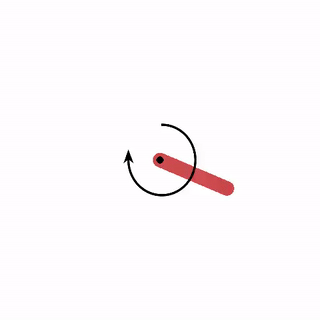
Gif taken from Google

In [1]:
import argparse
import gym
import numpy as np

import pickle
import sys
import tensorflow as tf
if "../" not in sys.path:
    sys.path.append("../")
from utils import utils_pg as utils
from utils import value_functions as vfuncs
from utils import logz
from utils import policies


def run_vpg( vf_params, logdir, env, sess, continuous_control,initial_stepsize,n_iter,render,gamma,min_timesteps_per_batch):
    

    ob_dim = env.observation_space.shape[0]
    print("observe dim",ob_dim)
    print("observe space",env.observation_space)
    if vf_type == 'nn':
        vf = vfuncs.NnValueFunction(session=sess, ob_dim=ob_dim, **vf_params)

    if continuous_control:
        ac_dim = env.action_space.shape[0]
        print("action dim",ac_dim)
        policyfn = policies.GaussianPolicy(sess, ob_dim, ac_dim)
    

    sess.__enter__() # equivalent to `with sess:`
    tf.global_variables_initializer().run() #
    total_timesteps = 0
    stepsize = initial_stepsize
    rewards_step = []
    step_iter = []
    for i in range(n_iter):
        print("\n********** Iteration %i ************"%i)

        # Collect paths until we have enough timesteps.
        timesteps_this_batch = 0
        paths = []
        while True:
            ob = env.reset()
            terminated = False
            obs, acs, rewards = [], [], []
            animate_this_episode = (len(paths) == 0 and (i%100 == 0) and render)
            while True:
                if animate_this_episode:
                    env.render()
                obs.append(ob)
                ac = policyfn.sample_action(ob)
                acs.append(ac)
                ob, rew, done, _ = env.step(ac)
                rewards.append(rew)
                if done:
                    break                    
            path = {"observation" : np.array(obs), "terminated" : terminated,
                    "reward" : np.array(rewards), "action" : np.array(acs)}
            paths.append(path)
            timesteps_this_batch += utils.pathlength(path)
            if timesteps_this_batch > min_timesteps_per_batch:
                break
        total_timesteps += timesteps_this_batch
        if (i%10==0):
            step_iter.append(i)
            rewards_step.append(np.mean(rewards[-10:]))
        # Estimate advantage function using baseline value function.
        # return_t: list of sum of discounted rewards (to end of episode), one per time
        # vpred_t: list of value function's predictions of components of return_t
        vtargs, vpreds, advs = [], [], []
        for path in paths:
            rew_t = path["reward"]
            return_t = utils.discount(rew_t, gamma)
            vpred_t = vf.predict(path["observation"])
            # Advantage calculation-- A(s_t,a_t) = Q(s_t,a_t) - V^(s_t)
            adv_t = return_t - vpred_t
            advs.append(adv_t)
            vtargs.append(return_t)
            vpreds.append(vpred_t)

        # Build arrays for policy update 
        ob_no = np.concatenate([path["observation"] for path in paths])
        ac_n  = np.concatenate([path["action"] for path in paths])
        adv_n = np.concatenate(advs)
        std_adv_n = (adv_n - adv_n.mean()) / (adv_n.std() + 1e-8) # standardizing advantage function (baseline subtraction and unit deviation)
    
        vtarg_n = np.concatenate(vtargs)
        vpred_n = np.concatenate(vpreds)
        vf.fit(ob_no, vtarg_n)

        # Policy update, plus diagnostics stuff. Is there a better way to handle
        # the continuous vs discrete control cases?
        
        surr_loss, oldmean_na, oldlogstd_a = policyfn.update_policy(
                    ob_no, ac_n, std_adv_n, stepsize)
        # kl, ent = policyfn.kldiv_and_entropy(ob_no, oldmean_na, oldlogstd_a)
        

        # Log diagnostics
        log_every_t_iter = 1
        if i % log_every_t_iter == 0:
            logz.log_tabular("EpRewMean", np.mean([path["reward"].sum() for path in paths]))
            logz.log_tabular("EpLenMean", np.mean([utils.pathlength(path) for path in paths]))
            
            logz.log_tabular("TimestepsSoFar", total_timesteps)
            # If you're overfitting, EVAfter will be way larger than EVBefore.
            # Note that we fit the value function AFTER using it to compute the
            # advantage function to avoid introducing bias
            logz.dump_tabular()
    return rewards_step,step_iter


if __name__ == "__main__":
#     p = argparse.ArgumentParser()
#     p.add_argument('envname', type=str)
    envname = 'Pendulum-v0'
    render = False
    do_not_save = True
    use_kl_heuristic = False 
    n_iter = 500
    seed = 0
    gamma = 0.97
    desired_kl = 2e-3
    min_timesteps_per_batch = 2500
    initial_stepsize = 1e-3
    # log_every_t_iter = 1
    vf_type = 'nn'
    nnvf_epochs = 20
    nnvf_ssize = 1e-3
   
#     args = p.parse_args()
    print(nnvf_epochs)
    # Handle value function type and the log directory (and save the args!).
    # assert args.vf_type == 'linear' or args.vf_type == 'nn'
    # vf_params = {}
    # outstr = 'linearvf-kl' +str(args.desired_kl) 
    if vf_type == 'nn':
        vf_params = dict(n_epochs=nnvf_epochs, stepsize=nnvf_ssize)
        outstr = 'nnvf-kl' +str(desired_kl)
    outstr += '-seed' +str(seed).zfill(2)
    logdir = 'outputs/' +envname+ '/' +outstr
    if do_not_save:
        logdir = None
    logz.configure_output_dir(logdir)
    if logdir is not None:
        with open(logdir+'/args.pkl', 'wb') as f:
            pickle.dump(args, f)
    print("Saving in logdir: {}".format(logdir))

    # Other stuff for seeding and getting things set up.
    tf.set_random_seed(seed)
    np.random.seed(seed)
    env = gym.make(envname)
    continuous = True
    if 'discrete' in str(type(env.action_space)).lower():
        continuous = False
    print("Continuous control? {}".format(continuous))
    tf_config = tf.ConfigProto(inter_op_parallelism_threads=1, 
                               intra_op_parallelism_threads=1) 
    sess = tf.Session(config=tf_config)

    rwd,step_i = run_vpg(vf_params, logdir, env, sess, continuous,initial_stepsize,n_iter,render,gamma,min_timesteps_per_batch)
    plt.plot(step_i,rwd)
    plt.show()


/home/bhavya/mll/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bhavya/mll/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bhavya/mll/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bhavya/mll/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

20
configure_output_dir: not storing the git diff, probably because you're not in a git repo
Logging data to /tmp/experiments/1574682949/log.txt
Saving in logdir: None
Continuous control? True
observe dim 3
observe space Box(3,)


action dim 1




********** Iteration 0 ************
-----------------------------------------------
|            EpRewMean |                -1267 |
|            EpLenMean |                  200 |
|       TimestepsSoFar |                 2600 |
-----------------------------------------------

********** Iteration 1 ************
-----------------------------------------------
|            EpRewMean |                -1247 |
|            EpLenMean |                  200 |
|       TimestepsSoFar |                 5200 |
-----------------------------------------------

********** Iteration 2 ************
-----------------------------------------------
|            EpRewMean |                -1108 |
|            EpLenMean |                  200 |
|       TimestepsS

KeyboardInterrupt: 

Show graphs and compare
With baselines
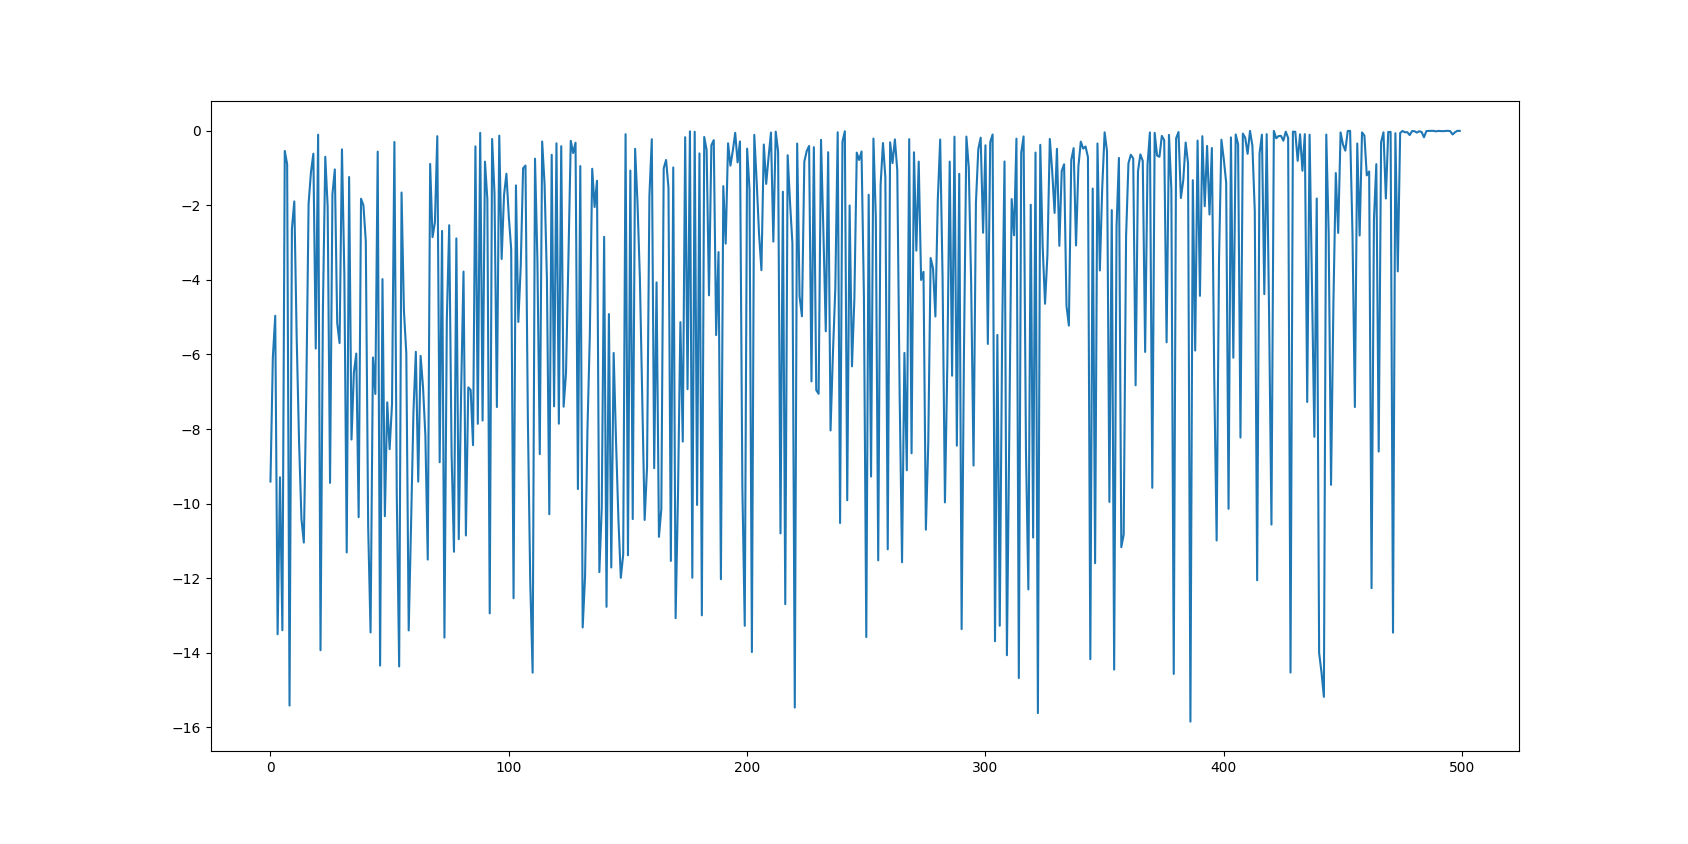
We can see the convergence is being achieved after 500 episodes

Without baselines
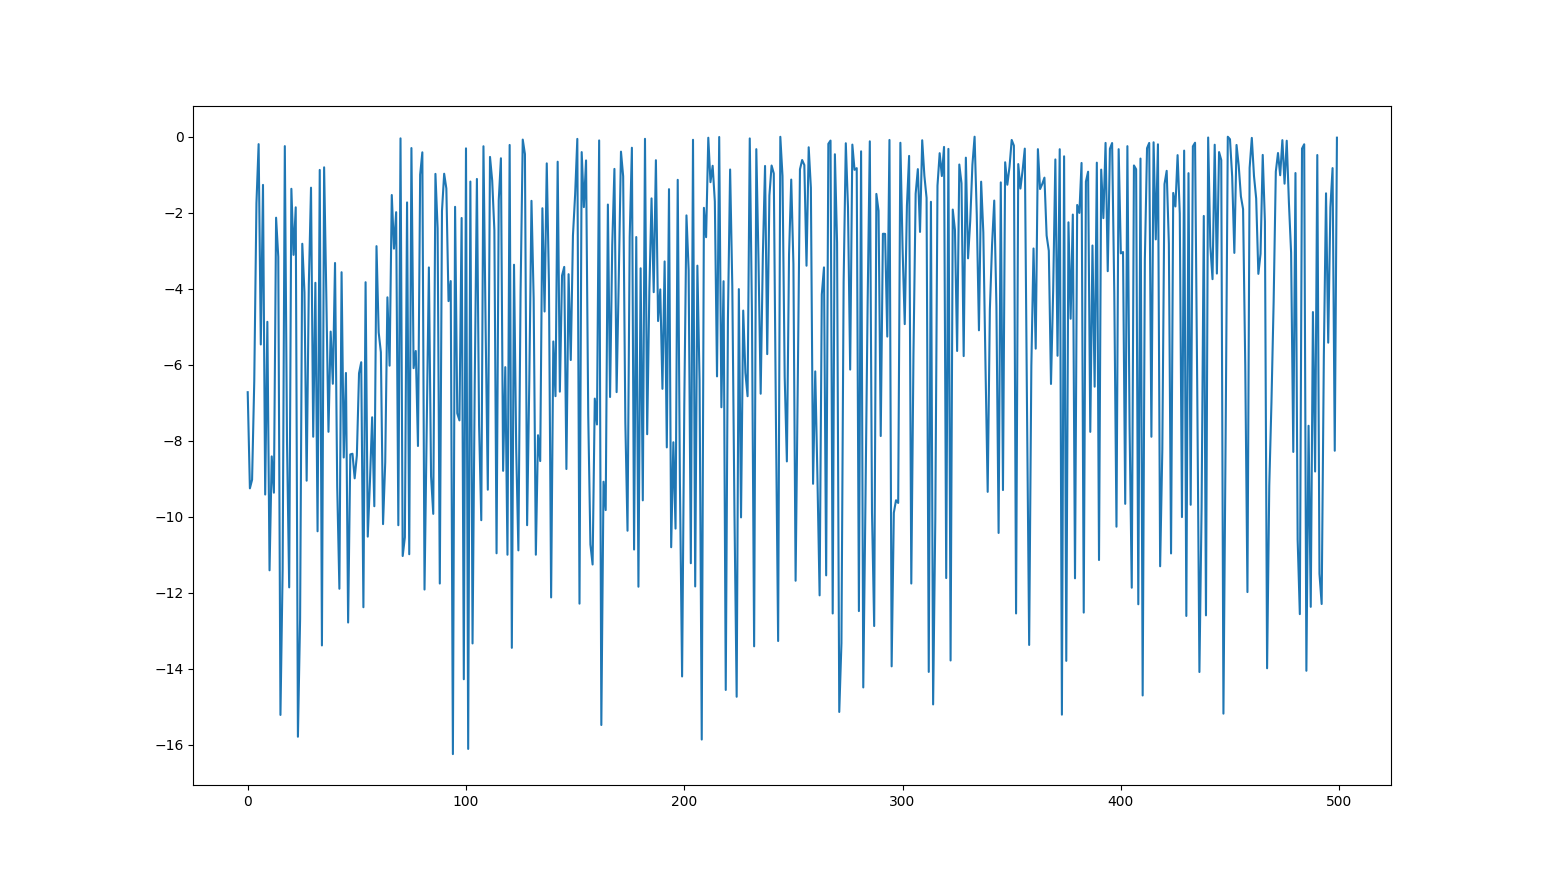
Doesn't converge after 500 episodes

6. Pendulum based on Actor Critic
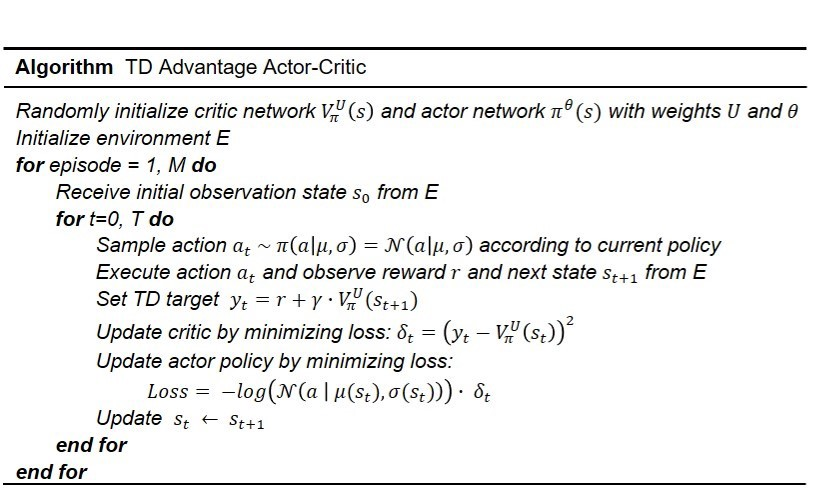

In [6]:
from collections import deque
import random
import torch
from torch import optim
from tqdm import tqdm
from utils import env 
from utils import models 
from matplotlib import pyplot as plt
import numpy as np

DISCOUNT = 0.99
ENTROPY_WEIGHT = 0.2
HIDDEN_SIZE = 32
LEARNING_RATE = 0.001
MAX_STEPS = 100000
BATCH_SIZE = 128
alpha = 0.995
REPLAY_SIZE = 100000
UPDATE_INTERVAL = 1
UPDATE_START = 10000
TEST_INTERVAL = 1000

env = env.Env()
actor = models.SoftActor(HIDDEN_SIZE)
critic_1 = models.Critic(HIDDEN_SIZE, state_action=True)
critic_2 = models.Critic(HIDDEN_SIZE, state_action=True)
value_critic = models.Critic(HIDDEN_SIZE)
target_value_critic = models.create_target_network(value_critic)
actor_optimiser = optim.Adam(actor.parameters(), lr=LEARNING_RATE)
critics_optimiser = optim.Adam(list(critic_1.parameters()) + list(critic_2.parameters()), lr=LEARNING_RATE)
value_critic_optimiser = optim.Adam(value_critic.parameters(), lr=LEARNING_RATE)
D = deque(maxlen=REPLAY_SIZE)


def test(actor):
  with torch.no_grad():
    # env = env.Env()
    state, done, total_reward = env.reset(), False, 0
    while not done:
      action = actor(state).mean  # Use purely exploitative policy at test time
      state, reward, done = env.step(action)
      total_reward += reward
    return total_reward

steps = []
total_rewards = []
total_avg_reward = []
steps_avg = []
state, done = env.reset(), False
pbar = tqdm(range(1, MAX_STEPS + 1), unit_scale=1, smoothing=0)
fig = plt.figure(1) 
for step in pbar:
  with torch.no_grad():
    if step < UPDATE_START:
      # To improve exploration take actions sampled from a uniform random distribution over actions at the start of training
      action = torch.tensor([[2 * random.random() - 1]])
    else:
      # Observe state s and select action a ~ μ(a|s)
      action = actor(state).sample()
    # Execute a in the environment and observe next state s', reward r, and done signal d to indicate whether s' is terminal
    next_state, reward, done = env.step(action)
    # Store (s, a, r, s', d) in replay buffer D
    D.append({'state': state, 'action': action, 'reward': torch.tensor([reward]), 'next_state': next_state, 'done': torch.tensor([done], dtype=torch.float32)})
    state = next_state
    # If s' is terminal, reset environment state
    if done:
      state = env.reset()

  if step > UPDATE_START and step % UPDATE_INTERVAL == 0:
    # Randomly sample a batch of transitions B = {(s, a, r, s', d)} from D
    batch = random.sample(D, BATCH_SIZE)
    batch = {k: torch.cat([d[k] for d in batch], dim=0) for k in batch[0].keys()}

    # Compute targets for Q and V functions
    y_q = batch['reward'] + DISCOUNT * (1 - batch['done']) * target_value_critic(batch['next_state'])
    policy = actor(batch['state'])
    action = policy.rsample()  # a(s) is a sample from μ(·|s) which is differentiable wrt θ via the reparameterisation trick
    weighted_sample_entropy = ENTROPY_WEIGHT * policy.log_prob(action).sum(dim=1)  # Note: in practice it is more numerically stable to calculate the log probability when sampling an action to avoid inverting tanh
    y_v = torch.min(critic_1(batch['state'], action.detach()), critic_2(batch['state'], action.detach())) - weighted_sample_entropy.detach()

    # Update Q-functions by one step of gradient descent
    value_loss = (critic_1(batch['state'], batch['action']) - y_q).pow(2).mean() + (critic_2(batch['state'], batch['action']) - y_q).pow(2).mean()
    critics_optimiser.zero_grad()
    value_loss.backward()
    critics_optimiser.step()

    # Update V-function by one step of gradient descent
    value_loss = (value_critic(batch['state']) - y_v).pow(2).mean()
    value_critic_optimiser.zero_grad()
    value_loss.backward()
    value_critic_optimiser.step()

    # Update policy by one step of gradient ascent
    policy_loss = (weighted_sample_entropy - critic_1(batch['state'], action)).mean()
    actor_optimiser.zero_grad()
    policy_loss.backward()
    actor_optimiser.step()

    # Update target value network
    models.update_target_network(value_critic, target_value_critic, alpha)

  if step > UPDATE_START and step % TEST_INTERVAL == 0:
    actor.eval()
    total_reward = test(actor)
    pbar.set_description('Step: %i | Reward: %f' % (step, total_reward))
    steps.append(step)
    total_rewards.append(total_reward)
    if step %100 == 0:
      total_avg_reward.append(np.mean(total_rewards[-100:]))
      steps_avg.append(step)
    # plot(step, total_reward, 'sac')
    actor.train()

plt.plot(steps_avg, total_avg_reward)
plt.show()


Step: 13000 | Reward: -1158.537587:  14%|█▎        | 13.5k/100k [00:23<02:33, 564it/s]  

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

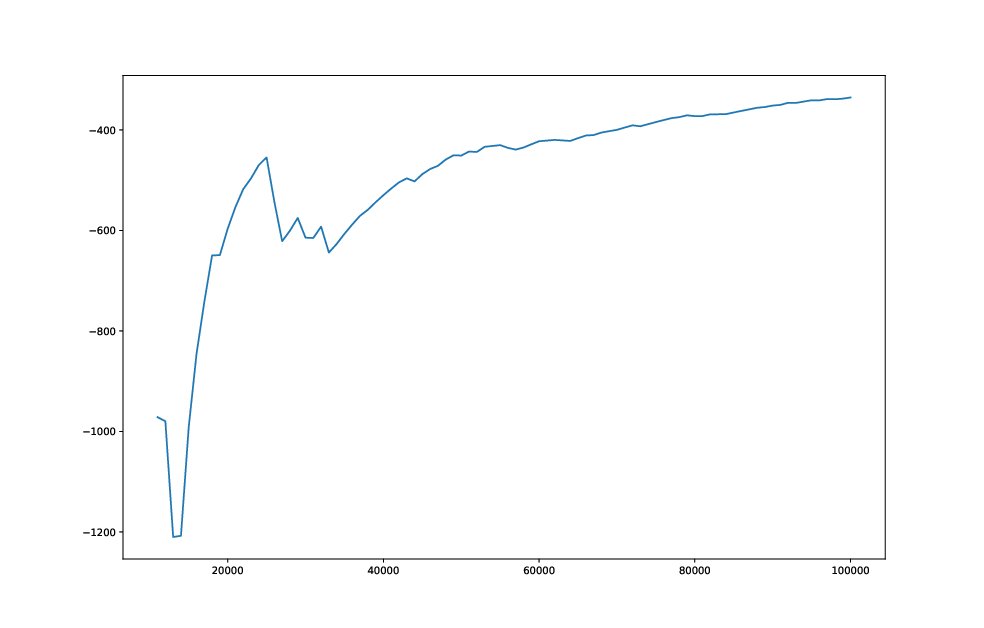

7. Gaussian policy has been employed in solving Pendulum vanilla polciy gradeint problem 